In [8]:
import numpy as np
from scipy.fft import fft
import sounddevice as sd

# Sample rate and duration
Fs = 44100  # in Hz, the rate at which you Fs the signal

# Base frequency for A4
A4 = 440.0

# Function to generate the first six harmonics of a base frequency
def harmonics(base_freq):
    return [base_freq * (i + 1) for i in range(6)]

# Update the frequency dictionary with C# and F#
frequency = {
    'a': harmonics(2 ** (0 / 12) * A4),  # A (same as A4)
    'a#': harmonics(2 ** (1 / 12) * A4),  # A# (same as A4)
    'b': harmonics(2 ** (2 / 12) * A4),  # B (two semitones above A4)
    'c': harmonics(2 ** (3 / 12) * A4),  # C
    'c#': harmonics(2 ** (4 / 12) * A4),
    'd': harmonics(2 ** (5 / 12) * A4),
    'd#': harmonics(2 ** (6 / 12) * A4),   
    'e': harmonics(2 ** (7 / 12) * A4),
    'f': harmonics(2 ** (8 / 12) * A4),  
    'f#': harmonics(2 ** (9 / 12) * A4),
    'g': harmonics(2 ** (10 / 12) * A4),
    'g#': harmonics(2 ** (11 / 12) * A4),
    'A': harmonics(2 * 2 ** (0 / 12) * A4),  # A one octave above A4 (880 Hz)
    'B': harmonics(2 * 2 ** (4 / 12) * A4)   # B one octave above the B below middle C
}

def playChord(note, T):
    # Create a time vector and a sine wave signal
    t = np.linspace(0, T, int(Fs * T), endpoint=False)
    chord = 0
    for i in frequency[note]:
        chord += np.sin(2 * np.pi * i * t)
    signal = chord

        # Normalization
    chord /= len(frequency[note])

    # Basic reverb effect
    num_echoes = 10
    initial_delay = 0.05  # 50 milliseconds initial delay
    decay_factor = 0.2  # Each echo has 60% of the previous echo's amplitude

    for i in range(1, num_echoes + 1):
        echo_delay = int(i * initial_delay * Fs)
        echo = np.zeros_like(chord)
        echo[echo_delay:] = chord[:-echo_delay] * (decay_factor ** i)
        chord += echo

    # Play the signal
    sd.play(signal, Fs) 
    sd.wait()
    return signal

def playRest(T):
    # Create a silent signal (array of zeros)
    rest_signal = np.zeros(int(Fs * T))
    
    # Play the silent signal (rest)
    sd.play(rest_signal, Fs)
    sd.wait()
    return rest_signal

import re

def playSequence(sequence):
    # Regular expression to match note-duration pairs
    pattern = r'([a-hA-B]#?\d+)'

    full_sequence = []

    # Find all matches in the sequence
    pairs = re.findall(pattern, sequence)

    for pair in pairs:
        # Extract note (including sharp) and duration
        note = ''.join([char for char in pair if char.isalpha() or char == '#'])
        duration = float(''.join([char for char in pair if char.isdigit()])) / 10


        # Check if the note is valid
        if note in frequency:
            full_sequence.append(playChord(note, duration))
        elif note == 'h':
            full_sequence.append(playRest(duration))
        else:
            print(f"Invalid note '{note}' encountered. Skipping.")
    full_signal = np.concatenate(full_sequence)
    return full_signal
# Example usage
#you are my sunshine
#playSequence('a1b1c#1d2d2h1d1a1b1c#2c#2h1a1b1c#1d2f#2f#1e1d1c#4')
#playSequence('a1b1c#1d2f#2f#1e1d1c#2a2h2a1b1c#2d1b2b1c#1a4')
#bye bye bye
song = playSequence('e4d2d2d2c2e4a4d2d2d2c2e4a4d2d2d2e2f4e2d2d2c2e2d2c4a4d2d2d2c2e4a4d2c2d2c2e4a4d2d2d2e2f4e4d2c2e2d2c4')
#playSequence('c4a4d2d2d2c2e4a4d2c2d2c2e4a4d2d2d2e2f4e4d2c2e2d2c4')
#shivers
#playSequence('b2b2b2b2b2b2a2b4h4h2h1b2b2b2b2a2a2a2a4d4d4h2')
#playSequence('d2d2d4a4a1a4d4d4h2h1c2d2c2d2c2d2c2')

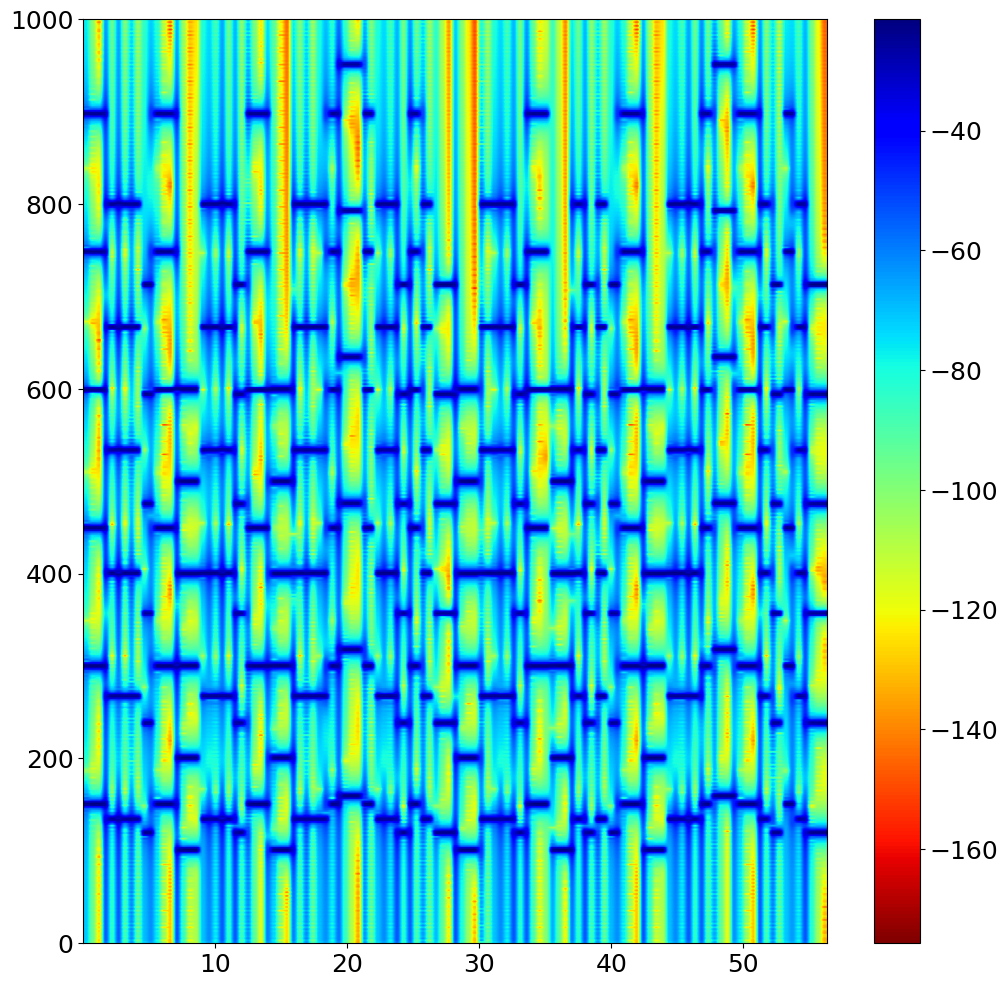

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size' : 18})

dt = 0.0001
fs = 1/dt
plt.specgram(song, NFFT=5000, Fs=fs, noverlap=100,cmap='jet_r')
plt.colorbar()
plt.ylim(bottom=0,top=1000)

plt.show()

(0.0, 60000.0)

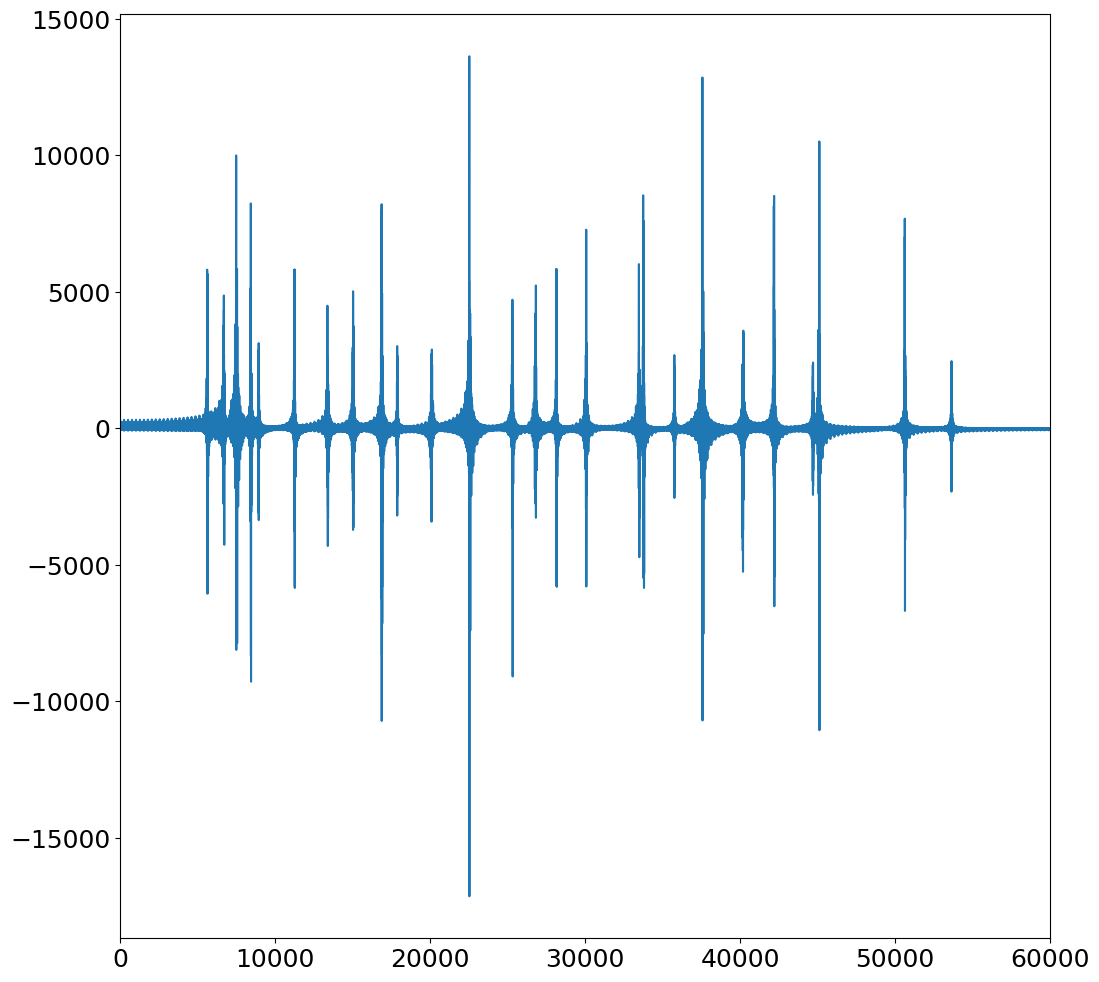

In [21]:
fft = np.fft.fft(song)
x = np.arange(0,len(fft.real),1)

plt.plot(x, fft)
plt.xlim(left=0, right=60000)

In [24]:
from pydub import AudioSegment

# Assuming 'song' is your NumPy audio array
# Ensure the array is in the correct format (int16)
song = np.int16(song / np.max(np.abs(song)) * 32767)

# Convert to bytes
raw_audio = song.tobytes()

# Create an AudioSegment instance
audio_segment = AudioSegment(
    raw_audio, 
    frame_rate=44100,  # Sample rate
    sample_width=song.dtype.itemsize,  # Sample width in bytes
    channels=1  # Number of channels
)

# To change playback speed (e.g., slow down by 25%)
playback_speed = 0.75  # Less than 1 to slow down, more than 1 to speed up
audio_segment = audio_segment._spawn(audio_segment.raw_data, overrides={
    "frame_rate": int(audio_segment.frame_rate * playback_speed)
}).set_frame_rate(44100)

# Export to an MP3 file
audio_segment.export("output.mp3", format="mp3")

<_io.BufferedRandom name='output.mp3'>